In [378]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar
import scipy
import pickle
import cPickle


import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Lasso

In [301]:
all_data_list = []
for year in range(1990,2017):
    data = pd.read_csv('{}_Output.csv'.format(year), header=None)
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']

In [302]:
data['yearmonth'] = map(lambda x: x[:7], data.date)

In [318]:
data.dropna(inplace=True)

In [303]:
def getStems(lead):
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    return map(lambda x: stemmer.stem(x.decode('utf-8')), tokens)

In [304]:
def joinstems(stemlist):
    return ' '.join(stem for stem in stemlist)

In [320]:
stems = map(getStems, data.lead)

In [321]:
data['leadstems'] = map(joinstems, stems)

In [325]:
data.dropna(inplace=True)

In [329]:
data.to_csv('allDataWithStems.csv', encoding='utf-8')

In [337]:
data = pd.read_csv('allDataWithStems.csv', index_col=0)

In [338]:
data.dropna(inplace=True)

In [340]:
data.to_csv('allDataWithStems.csv', encoding='utf-8')

## Count Vectorize

In [341]:
countVec = CountVectorizer(stop_words='english', max_df=0.8, min_df=.005, strip_accents='unicode')
wordMatrix = countVec.fit_transform(data.leadstems)

In [347]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return scipy.sparse.csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [344]:
save_sparse_csr('unigramWordMatrix.npz',wordMatrix)

In [348]:
wordMatrix2 = load_sparse_csr('unigramWordMatrix.npz')

In [350]:
wordMatrix2.shape

(577607, 1088)

In [351]:
unigramVocab = countVec.get_feature_names()

In [361]:
with open("unigramVocab.pkl", "wb") as output_file:
    pickle.dump(unigramVocab, output_file)

In [362]:
with open("unigramVocab.pkl", "rb") as input_file:
    unigramVocab2 = pickle.load(input_file)

## LDA

In [366]:
num_topics=10
lda = LatentDirichletAllocation(n_topics=num_topics)

In [369]:
ldaDocs = lda.fit_transform(wordMatrix)

In [370]:
lda.components_.shape

(10, 1088)

In [377]:
type(lda.components_)

numpy.ndarray

In [376]:
type(ldaDocs)

numpy.ndarray

In [379]:
with open('ldaModel.pkl', 'wb') as filename:
    cPickle.dump(lda, filename)    

In [380]:
np.save('ldaDocScores', ldaDocs)

In [373]:
num_top_words = 15
topic_words = []

for topic in lda.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([unigramVocab[i] for i in word_idx])

In [374]:
topicDF = pd.DataFrame(topic_words)
topicDF.index = ['Topic {}'.format(i) for i in range(1,(num_topics+1))]
topicDF.columns = ['Stem {}'.format(i) for i in range(1,(num_top_words+1))]
topicDF

,Stem 1,Stem 2,Stem 3,Stem 4,Stem 5,Stem 6,Stem 7,Stem 8,Stem 9,Stem 10,Stem 11,Stem 12,Stem 13,Stem 14,Stem 15
Topic 1,wednesday,tuesday,monday,global,central,britain,market,time,econom,dollar,minist,europ,like,world,chang
Topic 2,bank,rate,european,economi,say,rais,year,british,cost,govern,debt,job,feder,bond,reserv
Topic 3,compani,said,billion,busi,year,oper,china,corpor,plan,growth,maker,euro,profit,product,yesterday
Topic 4,stock,trade,market,price,percent,fell,exchang,street,wall,yesterday,investor,day,new,rose,equiti
Topic 5,new,use,network,car,motor,investig,internet,busi,power,peopl,televis,rival,news,general,build
Topic 6,thursday,oil,percent,month,report,accord,price,increas,energi,year,friday,consum,week,sinc,gas
Topic 7,execut,new,group,compani,chief,mr,firm,manag,said,fund,york,presid,invest,offic,hold
Topic 8,million,quarter,percent,year,loss,tax,said,result,cent,expect,onlin,revenu,sale,report,merger
Topic 9,share,earn,compani,corp,net,report,sale,31,lead,16,30,25,revenu,cent,sept
Topic 10,bank,said,unit,state,million,financi,buy,agre,deal,feder,regul,pay,govern,secur,court


## Group by month

In [375]:
grouped = data.groupby('yearmonth')

In [381]:
topicsByMonth = np.zeros((len(grouped.groups.keys()),ldaDocs.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    topicsByMonth[i] = np.mean(ldaDocs[grouped.get_group(month).index], axis=0)

In [382]:
topicsByMonth.shape

(321, 10)

In [384]:
np.save('topicsByMonth', topicsByMonth)

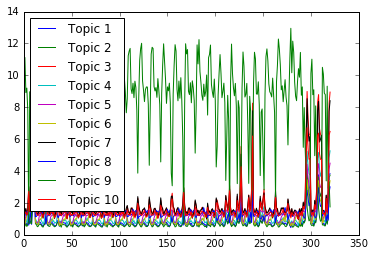

In [383]:
for topic in range(topicsByMonth.shape[1]):
    plt.plot(topicsByMonth[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')

In [295]:
topicsYearlyDiff = topicsByMonth[12:,:] - topicsByMonth[:-12,:]

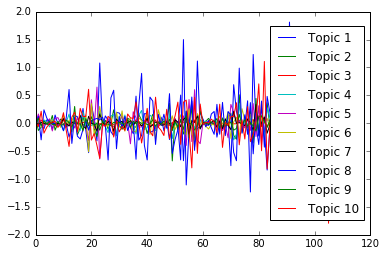

In [296]:
for topic in range(topicsYearlyDiff.shape[1]):
    plt.plot(topicsYearlyDiff[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')

## CCI

In [297]:
CCI = pd.read_csv('CCI.csv')[['TIME','Value']]
CCI.set_index('TIME', inplace=True)
CCI.head()

,Value
TIME,
1960-01,101.5840
1960-02,101.3255
1960-03,101.1023
1960-04,100.9791
1960-05,101.0102


In [298]:
CCIlimited = CCI.iloc[np.where(CCI.index=='1997-01')[0][0]:(np.where(CCI.index=='2006-12')[0]+1)[0]]

In [299]:
CCIlimited.shape

(120, 1)

## Assembling predictors

In [300]:
X = topicsByMonth

In [254]:
X = topicsYearlyDiff

In [255]:
X = np.hstack((topicsYearlyDiff[2:,:],topicsYearlyDiff[1:-1,:],topicsYearlyDiff[:-2,:]))

In [256]:
X.shape

(106, 15)

In [257]:
y = CCIlimited.Value.values[14:] - CCIlimited.Value.values[13:-1]

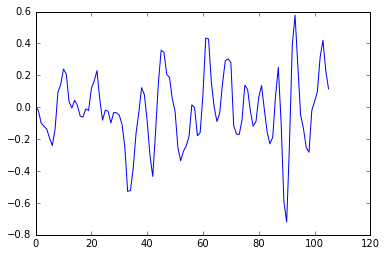

In [258]:
plt.plot(y)

In [267]:
lasso = Lasso(alpha=.005)

In [268]:
lasso.fit(X[:-10,:],y[:-10])
pred = lasso.predict(X[-10:,:])
lasso.score(X[-10:,:],y[-10:])

-0.2556732751978561

In [269]:
X[-10:,:].shape

(10, 15)

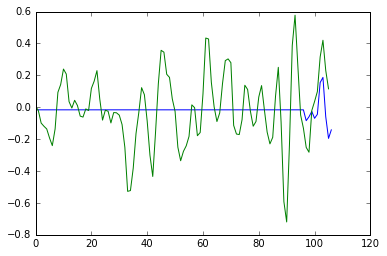

In [270]:
plt.plot(np.concatenate((np.mean(y)*np.ones(97),pred)))
plt.plot(y)

In [271]:
lasso.fit(X[:-10,:],y[:-10])
pred = lasso.predict(X)
lasso.score(X[-10:,:],y[-10:])

-0.2556732751978561

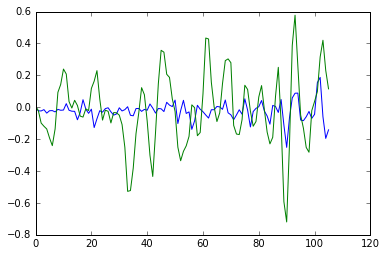

In [272]:
plt.plot(pred)
plt.plot(y)

In [273]:
Xdiff = topicsYearlyDiff[1:,:] - topicsYearlyDiff[:-1,:]

In [274]:
Xdiff.shape

(107, 5)

In [275]:
y = CCIlimited.Value.values[13:] - CCIlimited.Value.values[12:-1]

In [276]:
y.shape

(107,)

In [277]:
lasso = Lasso(alpha=.0001)

In [278]:
lasso.fit(Xdiff[:-10,:],y[:-10])
pred = lasso.predict(Xdiff[-10:,:])
lasso.score(Xdiff[-10:,:],y[-10:])

-0.23037201746794356

In [279]:
lasso.fit(Xdiff[:-10,:],y[:-10])
pred = lasso.predict(Xdiff)
lasso.score(Xdiff[-10:,:],y[-10:])

-0.23037201746794356

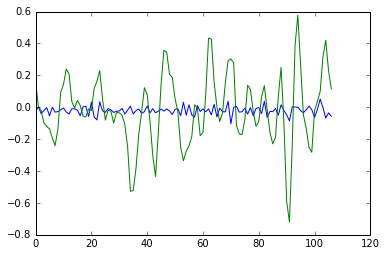

In [280]:
plt.plot(pred)
plt.plot(y)

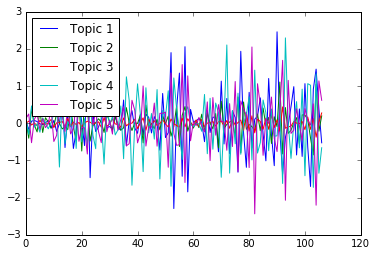

In [281]:
for topic in range(Xdiff.shape[1]):
    plt.plot(Xdiff[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')